In [16]:
# =============================================================================
# CBB ELO SYSTEM - FOUR FACTORS + SUPER ELO (FAST VERSION)
# =============================================================================

import pandas as pd
import numpy as np
from datetime import datetime

# -----------------------------------------------------------------------------
# 1. LOAD DATA
# -----------------------------------------------------------------------------

data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CBB\Data'
df = pd.read_csv(f'{data_path}\\barttorvik_games_2025.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Games loaded: {len(df)}")

teams = sorted(df['team'].unique())
team_to_idx = {t: i for i, t in enumerate(teams)}
n_teams = len(teams)
print(f"Teams: {n_teams}")

# -----------------------------------------------------------------------------
# 2. VECTORIZE GAME DATA
# -----------------------------------------------------------------------------

print("\nVectorizing game data...")

# Map teams to indices
df['team_idx'] = df['team'].map(team_to_idx)
df['opp_idx'] = df['opponent'].map(team_to_idx)

# Venue encoding: H=1, A=-1, N=0
df['venue_mult'] = df['venue'].map({'H': -1, 'A': 1, 'N': 0})

# Extract arrays
team_idx = df['team_idx'].values
opp_idx = df['opp_idx'].values
venue_mult = df['venue_mult'].values
mov = df['mov'].values
n_games = len(df)
team_games_count = np.bincount(team_idx, minlength=n_teams)

# Factor columns
FACTORS = ['efg', 'tov', 'orb', 'ftr']

# Offensive: my stats
off_cols = ['efg', 'tov_pct', 'orb_pct', 'ftr']
# Defensive: opponent's stats against me
def_cols = ['opp_efg', 'opp_tov_pct', 'opp_orb_pct', 'opp_ftr']

# Higher is better flags
off_higher_better = np.array([True, False, True, True])   # eFG+, TOV-, ORB+, FTR+
def_higher_better = np.array([False, True, False, False]) # eFG-, TOV+, ORB-, FTR-

# Extract raw values as arrays (n_games x 4)
off_vals = df[off_cols].values
def_vals = df[def_cols].values

# Calculate league means and stds
off_means = np.nanmean(off_vals, axis=0)
off_stds = np.nanstd(off_vals, axis=0)
def_means = np.nanmean(def_vals, axis=0)
def_stds = np.nanstd(def_vals, axis=0)

print(f"Offensive means: {off_means}")
print(f"Defensive means: {def_means}")

# Z-score the values
off_z = (off_vals - off_means) / off_stds
def_z = (def_vals - def_means) / def_stds

# Flip signs where lower is better
off_z[:, ~off_higher_better] *= -1
def_z[:, ~def_higher_better] *= -1

# Convert to actual scores (sigmoid)
off_actual = 1 / (1 + np.exp(-off_z * 0.5))
def_actual = 1 / (1 + np.exp(-def_z * 0.5))

# Clip
off_actual = np.clip(off_actual, 0.001, 0.999)
def_actual = np.clip(def_actual, 0.001, 0.999)

# MOV dominance
mov_actual = 1 / (1 + np.exp(-mov / 10))
mov_actual = np.clip(mov_actual, 0.001, 0.999)

# -----------------------------------------------------------------------------
# 3. ESTIMATE HFA
# -----------------------------------------------------------------------------

print("\nEstimating HFA...")

home_mask = df['venue'] == 'H'
away_mask = df['venue'] == 'A'

# Offensive HFA (in z-score units)
off_hfa = np.zeros(4)
for i in range(4):
    home_mean = np.nanmean(off_vals[home_mask, i])
    away_mean = np.nanmean(off_vals[away_mask, i])
    diff = home_mean - away_mean
    off_hfa[i] = diff / off_stds[i]
    if not off_higher_better[i]:
        off_hfa[i] *= -1

# Defensive HFA
def_hfa = np.zeros(4)
for i in range(4):
    home_mean = np.nanmean(def_vals[home_mask, i])
    away_mean = np.nanmean(def_vals[away_mask, i])
    diff = home_mean - away_mean
    def_hfa[i] = diff / def_stds[i]
    if not def_higher_better[i]:
        def_hfa[i] *= -1

# MOV HFA
mov_hfa = (mov[home_mask].mean() - mov[away_mask].mean()) / 2

print(f"Offensive HFA (z): {off_hfa}")
print(f"Defensive HFA (z): {def_hfa}")
print(f"MOV HFA: {mov_hfa:.2f}")

# Scale HFA to Elo points (roughly)
HFA_SCALE = 100
off_hfa_elo = off_hfa * HFA_SCALE
def_hfa_elo = def_hfa * HFA_SCALE
mov_hfa_elo = mov_hfa * 10

print(f"MOV HFA (Elo Points): {mov_hfa_elo:.1f}")

# -----------------------------------------------------------------------------
# 3b. SEED INITIAL ELOS FROM TORVIK TEAM STATS
# -----------------------------------------------------------------------------

print("\nSeeding initial Elos from Torvik team stats...")

team_stats = pd.read_csv(f'{data_path}\\torvik_teamstats_2026.csv')

# Column mapping
torvik_cols = {
    'off_efg': ('Eff. FG%_Off.', True),   # (column, higher_is_better)
    'off_tov': ('Turnover%_Off.', False),
    'off_orb': ('Off. Reb%_Off.', True),
    'off_ftr': ('FT Rate_Off.', True),
    'def_efg': ('Eff. FG%_Def.', False),
    'def_tov': ('Turnover%_Def.', True),
    'def_orb': ('Off. Reb%_Def.', False),
    'def_ftr': ('FT Rate_Def.', False),
}

# Initialize Elo array
elo = np.full((n_teams, 9), 1500.0)

# Z-score each factor and convert to Elo
ELO_SPREAD = 150  # 1 std dev = 150 Elo points

for j, (factor, (col, higher_better)) in enumerate(torvik_cols.items()):
    values = []
    for team in teams:
        row = team_stats[team_stats['Team'] == team]
        if len(row) > 0:
            values.append(row[col].values[0])
        else:
            values.append(np.nan)
    
    values = np.array(values)
    z = (values - np.nanmean(values)) / np.nanstd(values)
    
    if not higher_better:
        z *= -1  # Flip so positive = good
    
    # Convert to Elo: 1500 + z * spread
    elo[:, j] = 1500 + np.nan_to_num(z, nan=0) * ELO_SPREAD

# MOV Elo stays at 1500 to start (no team-level MOV in this file)
# It will converge from game data

print(f"Seeded factor Elos from {len(team_stats)} teams")
print(f"Initial Elo std devs:")
for j, factor in enumerate(list(torvik_cols.keys()) + ['mov']):
    print(f"  {factor}: {np.std(elo[:, j]):.1f}")

# -----------------------------------------------------------------------------
# 4. ITERATIVE ELO - OPPONENT-ADJUSTED (CORRECTED)
# -----------------------------------------------------------------------------

print("\nRunning iterative Elo (opponent-adjusted)...")

ELO_DIVISOR = 400.0

# We need raw values (not pre-converted to actuals) for opponent adjustment
off_vals_raw = df[off_cols].values  # Raw offensive stats
def_vals_raw = df[def_cols].values  # Raw defensive stats

for iteration in range(100):
    # Get opponent Elos for each game
    opp_def_elo = elo[opp_idx, 4:8]
    opp_off_elo = elo[opp_idx, 0:4]
    opp_mov_elo = elo[opp_idx, 8]
    
    # Raw z-scores
    off_z_raw = (off_vals_raw - off_means) / off_stds
    off_z_raw[:, ~off_higher_better] *= -1
    
    def_z_raw = (def_vals_raw - def_means) / def_stds
    def_z_raw[:, ~def_higher_better] *= -1
    
    # DIRECT SCALING: 1 std dev = 150 Elo points (skip sigmoid)
    Z_TO_ELO = 250
    off_log_odds = off_z_raw * Z_TO_ELO
    def_log_odds = def_z_raw * Z_TO_ELO
    
    # MOV keeps its own scaling
    mov_actual_iter = 1 / (1 + np.exp(-mov / 10))
    mov_actual_iter = np.clip(mov_actual_iter, 0.001, 0.999)
    mov_log_odds = -ELO_DIVISOR * np.log10((1 - mov_actual_iter) / mov_actual_iter)
    
    # HFA adjustments
    off_hfa_adj = venue_mult[:, np.newaxis] * off_hfa_elo
    def_hfa_adj = venue_mult[:, np.newaxis] * def_hfa_elo
    mov_hfa_adj = venue_mult * mov_hfa_elo
    
    # Implied ratings
    off_implied = opp_def_elo + off_hfa_adj + off_log_odds
    def_implied = opp_off_elo + def_hfa_adj + def_log_odds
    mov_implied = opp_mov_elo + mov_hfa_adj + mov_log_odds
    
    # Aggregate implied ratings per team
    implied_sum = np.zeros((n_teams, 9))
    counts = np.zeros((n_teams, 9))
    
    for j in range(4):
        valid_off = ~np.isnan(off_implied[:, j])
        np.add.at(implied_sum[:, j], team_idx[valid_off], off_implied[valid_off, j])
        np.add.at(counts[:, j], team_idx[valid_off], 1)
        
        valid_def = ~np.isnan(def_implied[:, j])
        np.add.at(implied_sum[:, 4+j], team_idx[valid_def], def_implied[valid_def, j])
        np.add.at(counts[:, 4+j], team_idx[valid_def], 1)
    
    np.add.at(implied_sum[:, 8], team_idx, mov_implied)
    np.add.at(counts[:, 8], team_idx, 1)
    
    # Average implied rating from games
    counts[counts == 0] = 1
    implied_avg = implied_sum / counts
    
    # BLEND: new_elo = weighted average of prior and implied
    # Teams with more games trust implied more; fewer games trust prior more
    game_weight = np.minimum(counts / 10, 1.0)  # Max out at 10 games
    new_elo = (1 - game_weight) * elo + game_weight * implied_avg
    
    # Center at 1500
    for j in range(9):
        new_elo[:, j] = new_elo[:, j] - np.mean(new_elo[:, j]) + 1500
    
    max_change = np.max(np.abs(new_elo - elo))
    elo = new_elo
    
    if max_change < 0.1:
        print(f"Converged at iteration {iteration}")
        break

if iteration == 99:
    print(f"Did not fully converge, max_change = {max_change:.2f}")


# Diagnostic
print(f"\nFactor Elo Std Devs:")
labels = ['off_efg', 'off_tov', 'off_orb', 'off_ftr', 'def_efg', 'def_tov', 'def_orb', 'def_ftr', 'mov']
for j, label in enumerate(labels):
    print(f"  {label}: {np.std(elo[:, j]):.1f}")

# -----------------------------------------------------------------------------
# 5. SUPER ELO
# -----------------------------------------------------------------------------

print("\nCalculating Super Elo...")

# Weights: off_efg, off_tov, off_orb, off_ftr, def_efg, def_tov, def_orb, def_ftr, mov
WEIGHTS = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0])

# Z-score each column
elo_z = (elo - np.mean(elo, axis=0)) / np.std(elo, axis=0)

# Weighted average of z-scores
super_z = np.sum(elo_z * WEIGHTS, axis=1) / np.sum(WEIGHTS)

# Convert back to Elo scale using MOV Elo's NATURAL spread (not forced)
mov_mean = np.mean(elo[:, 8])
mov_std = np.std(elo[:, 8])

super_elo = mov_mean + super_z * mov_std

# After Super Elo calculation, add this diagnostic:

# Model 1: MOV only
mov_only_z = (elo[:, 8] - np.mean(elo[:, 8])) / np.std(elo[:, 8])
mov_only_elo = elo[:, 8]
print(f"\nMOV Elo std dev: {np.std(mov_only_elo):.1f}")
print(f"Super Elo std dev: {np.std(super_elo):.1f}")
print(f"Correlation between Super Elo and MOV Elo: {np.corrcoef(super_elo, elo[:, 8])[0,1]:.3f}")

# -----------------------------------------------------------------------------
# 6. BUILD RESULTS
# -----------------------------------------------------------------------------

print("\nBuilding results...")

# Count wins/games per team
team_wins = np.zeros(n_teams)

for i in range(n_games):
    t = team_idx[i]
    if df.iloc[i]['win'] == True:  # Use the actual win column, not mov > 0
        team_wins[t] += 1

# Build dataframe
results = pd.DataFrame({
    'team': teams,
    'games': team_games_count.astype(int),
    'wins': team_wins.astype(int),
    'losses': (team_games_count - team_wins).astype(int),
    'super_elo': super_elo,
    'mov_elo': elo[:, 8],
    'off_efg_elo': elo[:, 0],
    'off_tov_elo': elo[:, 1],
    'off_orb_elo': elo[:, 2],
    'off_ftr_elo': elo[:, 3],
    'def_efg_elo': elo[:, 4],
    'def_tov_elo': elo[:, 5],
    'def_orb_elo': elo[:, 6],
    'def_ftr_elo': elo[:, 7],
})

results = results.sort_values('super_elo', ascending=False).reset_index(drop=True)
results['rank'] = range(1, len(results) + 1)

# -----------------------------------------------------------------------------
# 7. DISPLAY
# -----------------------------------------------------------------------------

print("\n" + "="*120)
print("TOP 25 - SUPER ELO RANKINGS")
print("="*120)

display_cols = ['rank', 'team', 'wins', 'losses', 'super_elo', 'mov_elo',
                'off_efg_elo', 'def_efg_elo', 'off_tov_elo', 'def_tov_elo']
print(results[display_cols].head(25).to_string(index=False))

# Save
results.to_csv(f'{data_path}\\cbb_super_elo_2025.csv', index=False)
print(f"\nSaved to: {data_path}\\cbb_super_elo_2025.csv")

Games loaded: 11528
Teams: 364

Vectorizing game data...
Offensive means: [51.03186155 17.19378036 29.55520472 33.72708189]
Defensive means: [51.03186155 17.19378036 29.55520472 33.72708189]

Estimating HFA...
Offensive HFA (z): [0.3537923  0.27592388 0.21982936 0.30210844]
Defensive HFA (z): [0.3537923  0.27592388 0.21982936 0.30210844]
MOV HFA: 5.70
MOV HFA (Elo Points): 57.0

Seeding initial Elos from Torvik team stats...
Seeded factor Elos from 377 teams
Initial Elo std devs:
  off_efg: 150.0
  off_tov: 150.0
  off_orb: 150.0
  off_ftr: 150.0
  def_efg: 150.0
  def_tov: 150.0
  def_orb: 150.0
  def_ftr: 150.0
  mov: 0.0

Running iterative Elo (opponent-adjusted)...
Converged at iteration 34

Factor Elo Std Devs:
  off_efg: 105.9
  off_tov: 93.3
  off_orb: 120.3
  off_ftr: 81.6
  def_efg: 97.1
  def_tov: 107.2
  def_orb: 80.0
  def_ftr: 92.1
  mov: 174.7

Calculating Super Elo...

MOV Elo std dev: 174.7
Super Elo std dev: 174.7
Correlation between Super Elo and MOV Elo: 1.000

Build

In [17]:
# =============================================================================
# OPTIMIZE PARAMETERS FOR SUPER ELO WEIGHTS (FAST VERSION) - CBB
# =============================================================================

import pandas as pd
import numpy as np
from scipy.optimize import minimize

print("="*70)
print("OPTIMIZING SUPER ELO WEIGHTS (FAST) - CBB")
print("="*70)

# 1. LOAD DATA AND COMPUTE FIXED ELOS
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CBB\Data'
df = pd.read_csv(f'{data_path}\\barttorvik_games_2025.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Games loaded: {len(df)}")

teams = sorted(set(df['team']) | set(df['opponent']))
team_to_idx = {t: i for i, t in enumerate(teams)}
n_teams = len(teams)
print(f"Teams: {n_teams}")

# Vectorize
df['team_idx'] = df['team'].map(team_to_idx)
df['opp_idx'] = df['opponent'].map(team_to_idx)
df['venue_mult'] = df['venue'].map({'H': -1, 'A': 1, 'N': 0})

team_idx = df['team_idx'].values
opp_idx = df['opp_idx'].values
venue_mult = df['venue_mult'].values
team_win = df['win'].values.astype(float)
n_games = len(df)

# Factor setup
off_cols = ['efg', 'tov_pct', 'orb_pct', 'ftr']
def_cols = ['opp_efg', 'opp_tov_pct', 'opp_orb_pct', 'opp_ftr']
off_higher_better = np.array([True, False, True, True])
def_higher_better = np.array([False, True, False, False])

off_vals = df[off_cols].values
def_vals = df[def_cols].values

off_means = np.nanmean(off_vals, axis=0)
off_stds = np.nanstd(off_vals, axis=0)
def_means = np.nanmean(def_vals, axis=0)
def_stds = np.nanstd(def_vals, axis=0)

# HFA estimation
home_mask = df['venue'] == 'H'
away_mask = df['venue'] == 'A'

off_hfa = np.zeros(4)
for i in range(4):
    home_mean = np.nanmean(off_vals[home_mask, i])
    away_mean = np.nanmean(off_vals[away_mask, i])
    diff = home_mean - away_mean
    off_hfa[i] = diff / off_stds[i]
    if not off_higher_better[i]:
        off_hfa[i] *= -1

def_hfa = np.zeros(4)
for i in range(4):
    home_mean = np.nanmean(def_vals[home_mask, i])
    away_mean = np.nanmean(def_vals[away_mask, i])
    diff = home_mean - away_mean
    def_hfa[i] = diff / def_stds[i]
    if not def_higher_better[i]:
        def_hfa[i] *= -1

mov_hfa_raw = (df[home_mask]['mov'].mean() - df[away_mask]['mov'].mean()) / 2
print(f"Estimated raw MOV HFA: {mov_hfa_raw:.2f}")

# Fixed params
HFA_SCALE = 100
off_hfa_elo = off_hfa * HFA_SCALE
def_hfa_elo = def_hfa * HFA_SCALE
mov_hfa_elo = mov_hfa_raw * 10

ELO_DIVISOR = 400.0

# Z-scores (keep for reference but don't convert to actuals for factors)
off_z = (off_vals - off_means) / off_stds
def_z = (def_vals - def_means) / def_stds
off_z[:, ~off_higher_better] *= -1
def_z[:, ~def_higher_better] *= -1

mov = df['mov'].values
mov_actual = 1 / (1 + np.exp(-mov / 10))
mov_actual = np.clip(mov_actual, 0.001, 0.999)

# Load seed values from Torvik
print("Seeding initial Elos from Torvik team stats...")
team_stats = pd.read_csv(f'{data_path}\\torvik_teamstats_2026.csv')

torvik_cols = {
    'off_efg': ('Eff. FG%_Off.', True),
    'off_tov': ('Turnover%_Off.', False),
    'off_orb': ('Off. Reb%_Off.', True),
    'off_ftr': ('FT Rate_Off.', True),
    'def_efg': ('Eff. FG%_Def.', False),
    'def_tov': ('Turnover%_Def.', True),
    'def_orb': ('Off. Reb%_Def.', False),
    'def_ftr': ('FT Rate_Def.', False),
}

elo = np.full((n_teams, 9), 1500.0)
ELO_SPREAD = 250

for j, (factor, (col, higher_better)) in enumerate(torvik_cols.items()):
    values = []
    for team in teams:
        row = team_stats[team_stats['Team'] == team]
        if len(row) > 0:
            values.append(row[col].values[0])
        else:
            values.append(np.nan)
    values = np.array(values)
    z = (values - np.nanmean(values)) / np.nanstd(values)
    if not higher_better:
        z *= -1
    elo[:, j] = 1500 + np.nan_to_num(z, nan=0) * ELO_SPREAD

# Compute Elos with direct z-score scaling
Z_TO_ELO = 250

for iteration in range(100):
    opp_def_elo = elo[opp_idx, 4:8]
    opp_off_elo = elo[opp_idx, 0:4]
    opp_mov_elo = elo[opp_idx, 8]
    
    # Direct scaling for factors
    off_log_odds = off_z * Z_TO_ELO
    def_log_odds = def_z * Z_TO_ELO
    
    # MOV keeps sigmoid
    mov_log_odds = -ELO_DIVISOR * np.log10((1 - mov_actual) / mov_actual)
    
    off_hfa_adj = venue_mult[:, np.newaxis] * off_hfa_elo
    def_hfa_adj = venue_mult[:, np.newaxis] * def_hfa_elo
    mov_hfa_adj = venue_mult * mov_hfa_elo
    
    off_implied = opp_def_elo + off_hfa_adj + off_log_odds
    def_implied = opp_off_elo + def_hfa_adj + def_log_odds
    mov_implied = opp_mov_elo + mov_hfa_adj + mov_log_odds
    
    implied_sum = np.zeros((n_teams, 9))
    counts = np.zeros((n_teams, 9))
    
    for j in range(4):
        valid_mask = ~np.isnan(off_implied[:, j])
        np.add.at(implied_sum[:, j], team_idx[valid_mask], off_implied[valid_mask, j])
        np.add.at(counts[:, j], team_idx[valid_mask], 1)
        
        valid_mask = ~np.isnan(def_implied[:, j])
        np.add.at(implied_sum[:, 4+j], team_idx[valid_mask], def_implied[valid_mask, j])
        np.add.at(counts[:, 4+j], team_idx[valid_mask], 1)
    
    np.add.at(implied_sum[:, 8], team_idx, mov_implied)
    np.add.at(counts[:, 8], team_idx, 1)
    
    counts[counts == 0] = 1
    implied_avg = implied_sum / counts
    
    game_weight = np.minimum(counts / 10, 1.0)
    new_elo = (1 - game_weight) * elo + game_weight * implied_avg
    
    for j in range(9):
        new_elo[:, j] = new_elo[:, j] - np.mean(new_elo[:, j]) + 1500
    
    max_change = np.max(np.abs(new_elo - elo))
    elo = new_elo
    
    if max_change < 0.1:
        print(f"Elos converged at iteration {iteration}")
        break

print("Fixed Elos computed.\n")
print(f"Factor Elo Std Devs:")
labels = ['off_efg', 'off_tov', 'off_orb', 'off_ftr', 'def_efg', 'def_tov', 'def_orb', 'def_ftr', 'mov']
for j, label in enumerate(labels):
    print(f"  {label}: {np.std(elo[:, j]):.1f}")

# 2. FAST OBJECTIVE FUNCTION
def evaluate_model_fast(params):
    weights = np.array(params)
    
    # Prevent degenerate solutions - if all weights near zero, return bad score
    if np.sum(weights) < 0.1:
        return 10.0  # Penalty for degenerate solution
    
    # Normalize weights to sum to 1 (removes scale ambiguity)
    weights_norm = weights / np.sum(weights)
    
    # Super Elo - use normalized weights
    elo_z = (elo - np.mean(elo, axis=0)) / np.std(elo, axis=0)
    super_z = np.sum(elo_z * weights_norm, axis=1)  # No division needed now
    
    # Scale to MOV Elo's natural spread
    mov_mean = np.mean(elo[:, 8])
    mov_std = np.std(elo[:, 8])
    super_elo = mov_mean + super_z * mov_std
    
    # Predictions
    pred_hfa = venue_mult * mov_hfa_elo
    pred = 1 / (1 + 10 ** ((super_elo[opp_idx] - super_elo[team_idx] + pred_hfa) / ELO_DIVISOR))
    pred = np.clip(pred, 0.001, 0.999)
    
    # Log loss
    log_loss_val = -np.mean(team_win * np.log(pred) + (1 - team_win) * np.log(1 - pred))
    
    # Calibration error
    cal_error = 0
    for bucket in [0.1, 0.3, 0.5, 0.7, 0.9]:
        mask = (pred >= bucket - 0.15) & (pred < bucket + 0.15)
        if mask.sum() > 5:
            cal_error += np.abs(pred[mask].mean() - team_win[mask].mean()) * mask.sum()
    cal_error /= n_games
    
    return log_loss_val + 0.3 * cal_error

# 3. TEST INITIAL SPEED
print("Testing evaluation speed...")
import time
start = time.time()
test_score = evaluate_model_fast([1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 2.0])
elapsed = time.time() - start
print(f"Single evaluation: {elapsed:.3f} seconds, score: {test_score:.5f}")
print(f"Estimated optimization time: {elapsed * 100:.0f} seconds\n")

# 4. RUN OPTIMIZATION
print("Optimizing...")
initial_guess = [1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 2.0]
bounds = [(0, 5)] * 9
result = minimize(
    evaluate_model_fast,
    initial_guess,
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 50, 'disp': True}
)

# 5. RESULTS
p = result.x
print("\n" + "="*70)
print("OPTIMIZED PARAMETERS")
print("="*70)
print(f"\nWeights (off_efg, off_tov, off_orb, off_ftr, def_efg, def_tov, def_orb, def_ftr, mov):")
print(np.round(p, 3))
print(f"\nFinal Score: {result.fun:.5f}")

# 6. QUICK VALIDATION
print("\n" + "="*70)
print("QUICK VALIDATION")
print("="*70)

weights = np.array(p)

elo_z = (elo - np.mean(elo, axis=0)) / np.std(elo, axis=0)
super_z = np.sum(elo_z * weights, axis=1) / np.sum(weights)
mov_mean = np.mean(elo[:, 8])
mov_std = np.std(elo[:, 8])
super_elo = mov_mean + super_z * mov_std

print(f"\nSuper Elo Std Dev: {np.std(super_elo):.1f}")
print(f"Super Elo Range: {super_elo.min():.1f} to {super_elo.max():.1f}")

pred_hfa = venue_mult * mov_hfa_elo
pred = 1 / (1 + 10 ** ((super_elo[opp_idx] - super_elo[team_idx] + pred_hfa) / ELO_DIVISOR))
pred = np.clip(pred, 0.001, 0.999)
accuracy = np.mean((pred > 0.5) == team_win)
print(f"Accuracy: {accuracy:.1%}")

print(f"\nCalibration:")
print(f" {'Bucket':<8} {'Count':<8} {'Pred':<8} {'Actual':<8} {'Diff':<8}")
for bucket in np.arange(0.1, 1.0, 0.1):
    mask = (pred >= bucket - 0.05) & (pred < bucket + 0.05)
    if mask.sum() > 0:
        print(f" {bucket:<8.1f} {mask.sum():<8} {pred[mask].mean():<8.3f} {team_win[mask].mean():<8.3f} {team_win[mask].mean() - pred[mask].mean():>+.3f}")

print(f"\nTop 10:")
sorted_idx = np.argsort(-super_elo)
for i in range(10):
    idx = sorted_idx[i]
    print(f" {i+1:2}. {teams[idx]:<25} {super_elo[idx]:.1f}")

print("\n" + "="*70)
print("COPY TO ELO COMPUTATION CELL:")
print("="*70)
print(f"WEIGHTS = np.array({np.round(p, 3).tolist()})")

OPTIMIZING SUPER ELO WEIGHTS (FAST) - CBB
Games loaded: 11528
Teams: 364
Estimated raw MOV HFA: 5.70
Seeding initial Elos from Torvik team stats...
Elos converged at iteration 40
Fixed Elos computed.

Factor Elo Std Devs:
  off_efg: 105.9
  off_tov: 93.3
  off_orb: 120.3
  off_ftr: 81.6
  def_efg: 97.1
  def_tov: 107.2
  def_orb: 80.0
  def_ftr: 92.1
  mov: 174.7
Testing evaluation speed...
Single evaluation: 0.001 seconds, score: 0.57214
Estimated optimization time: 0 seconds

Optimizing...

OPTIMIZED PARAMETERS

Weights (off_efg, off_tov, off_orb, off_ftr, def_efg, def_tov, def_orb, def_ftr, mov):
[0. 0. 0. 0. 0. 0. 0. 0. 5.]

Final Score: 0.53363

QUICK VALIDATION

Super Elo Std Dev: 174.7
Super Elo Range: 944.1 to 2011.7
Accuracy: 75.7%

Calibration:
 Bucket   Count    Pred     Actual   Diff    
 0.1      569      0.101    0.012    -0.089
 0.2      963      0.203    0.082    -0.121
 0.3      1401     0.304    0.193    -0.110
 0.4      1760     0.401    0.347    -0.054
 0.5      187

C:\Users\seanm\AppData\Local\Temp\ipykernel_53576\3368524571.py:236: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


Estimated HFA: 68.1
MODEL VALIDATION

1. ELO DISTRIBUTION
 Teams: 364
 Mean Elo: 1500.0
 Std Dev: 174.7
 Min: 944.0 (Mississippi Valley St.)
 Max: 2011.7 (Duke)
 Range: 1067.7

 Percentiles:
   1th: 1176.8
   5th: 1259.1
  25th: 1379.4
  50th: 1473.3
  75th: 1605.1
  95th: 1824.5
  99th: 1939.5
Fitted params: beta0=0.5354, beta1=0.0104, beta2=0.00000001
 Unique games: 5764

2. PREDICTION ACCURACY
 Games: 5764
 Correct predictions: 4369
 Accuracy: 75.8%

Game-by-game predictions saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CBB\Data\cbb_predictions_2026.csv
Total Unique Games: 5764

Top 10 Biggest Upsets:
Date         Winner               Loser                Score      Upset Prob
---------------------------------------------------------------------------
2024-11-06   Columbia             Villanova            90-80           98.4%
2025-01-30   Louisiana Monroe     South Alabama        62-58           97.2%
2024-11-08   Austin Peay          Butler               68-66           97.

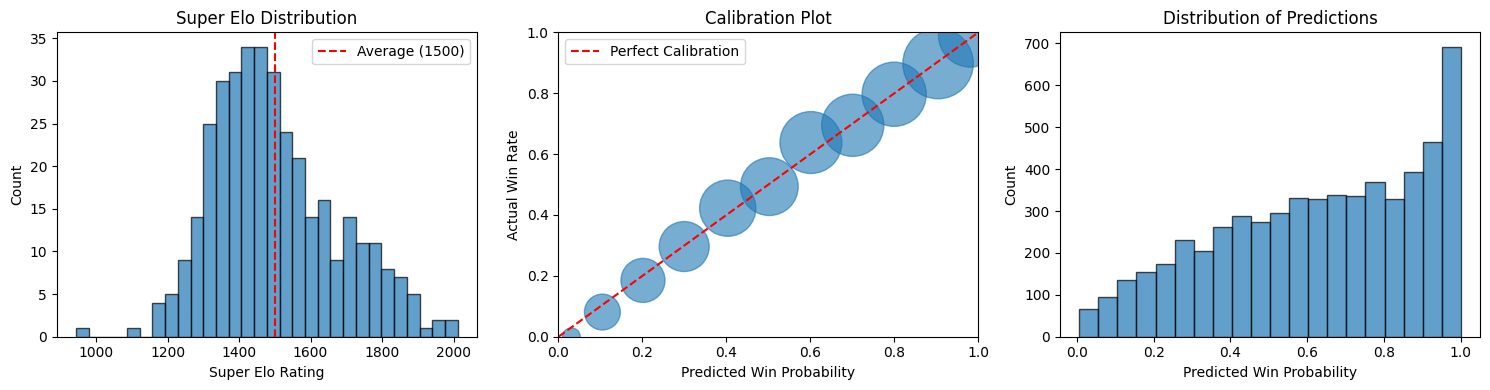


Visualization saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CBB\Data\model_validation.png


In [20]:
# =============================================================================
# MODEL VALIDATION (Robust Score-Based Logic)
# =============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Define Path (User Local)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CBB\Data'
games_out = f'{data_path}\\barttorvik_games_2025.csv'
teams_out = f'{data_path}\\cbb_super_elo_2025.csv'

# Load Data
df_games = pd.read_csv(games_out)
df_teams = pd.read_csv(teams_out)

# Filter to unique games (treat 'team' as focus where venue != 'A')
df_games = df_games[df_games['venue'] != 'A'].copy()

# Calculate mov_actual for HFA estimation
# Note: Ensure 'mov' column exists or calculate from scores
if 'mov' not in df_games.columns:
    df_games['mov'] = df_games['team_score'] - df_games['opp_score']
df_games['mov_actual'] = 1 / (1 + np.exp(-df_games['mov'] / 10))
df_games['mov_actual'] = np.clip(df_games['mov_actual'], 0.001, 0.999)

# Merge super_elo
df_games = df_games.merge(
    df_teams[['team', 'super_elo']].rename(columns={'super_elo': 'super_elo_team'}),
    on='team',
    how='left'
)
df_games = df_games.merge(
    df_teams[['team', 'super_elo']].rename(columns={'super_elo': 'super_elo_opp'}),
    left_on='opponent',
    right_on='team',
    how='left',
    suffixes=('', '_drop')
)
df_games = df_games.drop(columns=['team_drop'])

# Recalculate HFA from df_games
home_acts = []
for _, row in df_games.iterrows():
    if row['venue'] == 'H': # Only non-neutral for HFA
        home_acts.append(row['mov_actual'])
avg_home = np.mean(home_acts) if home_acts else 0.5
HFA = -400 * np.log10((1 - avg_home) / avg_home)
print(f"Estimated HFA: {HFA:.1f}")

print("="*80)
print("MODEL VALIDATION")
print("="*80)

# -----------------------------------------------------------------------------
# 1. ELO DISTRIBUTION ANALYSIS
# -----------------------------------------------------------------------------
elo_values = df_teams['super_elo'].tolist()
teams_list = df_teams['team'].tolist()
print(f"\n1. ELO DISTRIBUTION")
print(f" Teams: {len(teams_list)}")
print(f" Mean Elo: {np.mean(elo_values):.1f}")
print(f" Std Dev: {np.std(elo_values):.1f}")
min_team = df_teams.loc[df_teams['super_elo'].idxmin(), 'team']
max_team = df_teams.loc[df_teams['super_elo'].idxmax(), 'team']
print(f" Min: {min(elo_values):.1f} ({min_team})")
print(f" Max: {max(elo_values):.1f} ({max_team})")
print(f" Range: {max(elo_values) - min(elo_values):.1f}")

# Percentiles
print(f"\n Percentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f" {p:3}th: {np.percentile(elo_values, p):.1f}")

# -----------------------------------------------------------------------------
# FIT NEW PREDICTION FUNCTION (ON HOME GAMES)
# -----------------------------------------------------------------------------
# Filter to home games for fitting
home_df = df_games[df_games['venue'] == 'H'].copy()

# Elo diff (positive = home favorite)
home_df['elo_diff'] = home_df['super_elo_team'] - home_df['super_elo_opp']

# Actual home win
home_df['home_win'] = (home_df['team_score'] > home_df['opp_score']).astype(int)

# Add quadratic
home_df['elo_diff_sq'] = home_df['elo_diff'] ** 2

# Fit logistic
X = home_df[['elo_diff', 'elo_diff_sq']]
y = home_df['home_win']
model = LogisticRegression(fit_intercept=True)
model.fit(X, y)

# Params
beta0 = model.intercept_[0]
beta1, beta2 = model.coef_[0]
print(f"Fitted params: beta0={beta0:.4f}, beta1={beta1:.4f}, beta2={beta2:.8f}")

# -----------------------------------------------------------------------------
# 2. GAME-BY-GAME PREDICTION ACCURACY
# -----------------------------------------------------------------------------
# Deduplicate games BEFORE running predictions
# Keep Home games + Neutral games where team < opponent alphabetically
df_games_unique = df_games[
    (df_games['venue'] == 'H') |
    ((df_games['venue'] == 'N') & (df_games['team'] < df_games['opponent']))
].copy()
print(f" Unique games: {len(df_games_unique)}")

print(f"\n2. PREDICTION ACCURACY")
correct = 0
total = 0
predictions = [] # (predicted_prob, actual_outcome)
for _, row in df_games_unique.iterrows():
    team_elo = row['super_elo_team']
    opp_elo = row['super_elo_opp']
   
    # Elo diff (positive = team favorite; adjust for 'team' perspective)
    elo_diff = team_elo - opp_elo
   
    # Prediction - New Function
    if row['venue'] == 'H':
        # Use quadratic for home
        logit = beta0 + beta1 * elo_diff + beta2 * (elo_diff ** 2)
        pred_prob = 1 / (1 + np.exp(-logit))
    else:
        # For neutral, use linear (drop quadratic) or standard constant HFA
        pred_prob = 1 / (1 + 10 ** ((opp_elo - team_elo) / 400))  # No HFA on neutral
   
    # Actual Outcome (ROBUST FIX: Use Scores)
    if row['team_score'] > row['opp_score']:
        actual = 1
    elif row['team_score'] < row['opp_score']:
        actual = 0
    else:
        actual = 0.5 # Tie (Rare)
       
    predictions.append((pred_prob, actual))
   
    # Did we predict correctly? (>50% and won, or <50% and lost)
    if (pred_prob > 0.5 and actual == 1) or (pred_prob < 0.5 and actual == 0):
        correct += 1
    elif pred_prob == 0.5:
        correct += 0.5 # Tie
    elif actual == 0.5: # Game ended in tie
        correct += 0.5
       
    total += 1
print(f" Games: {total}")
print(f" Correct predictions: {correct}")
print(f" Accuracy: {correct/total:.1%}")

# -----------------------------------------------------------------------------
# 2b. SAVE GAME-BY-GAME PREDICTIONS (DE-DUPLICATED)
# -----------------------------------------------------------------------------
# Build predictions dataframe
pred_df = df_games_unique[['date', 'team', 'opponent', 'venue', 'team_score', 'opp_score',
                    'super_elo_team', 'super_elo_opp', 'mov_actual']].copy()
pred_df['pred_team_win_prob'] = [p for p, a in predictions]
pred_df['actual_team_win'] = [a for p, a in predictions]
pred_df['predicted_winner'] = pred_df.apply(
    lambda row: row['team'] if row['pred_team_win_prob'] > 0.5 else row['opponent'], axis=1
)
pred_df['actual_winner'] = pred_df.apply(
    lambda row: row['team'] if row['team_score'] > row['opp_score'] else row['opponent'], axis=1
)
pred_df['correct'] = pred_df['predicted_winner'] == pred_df['actual_winner']
pred_df['prediction_error'] = abs(pred_df['pred_team_win_prob'] - pred_df['actual_team_win'])
pred_df['surprise_factor'] = pred_df.apply(
    lambda row: row['pred_team_win_prob'] if row['actual_team_win'] == 0 else (1 - row['pred_team_win_prob']), axis=1
)
# --- DEDUPLICATION STEP ---
# Keep all Home games ('H')
# Keep Neutral games ('N') ONLY if team name < opponent name (alphabetical order)
pred_df = pred_df[
    (pred_df['venue'] == 'H') |
    ((pred_df['venue'] == 'N') & (pred_df['team'] < pred_df['opponent']))
].copy()
# Sort by surprise factor (biggest upsets first)
pred_df = pred_df.sort_values('surprise_factor', ascending=False)
# Save to CSV
pred_df.to_csv(f'{data_path}\\cbb_predictions_2025.csv', index=False)
print(f"\nGame-by-game predictions saved to {data_path}\\cbb_predictions_2026.csv")
print(f"Total Unique Games: {len(pred_df)}")
# Show biggest upsets
print(f"\nTop 10 Biggest Upsets:")
print(f"{'Date':<12} {'Winner':<20} {'Loser':<20} {'Score':<10} {'Upset Prob':>10}")
print("-" * 75)
for _, row in pred_df.head(10).iterrows():
    winner = row['actual_winner']
    loser = row['team'] if winner == row['opponent'] else row['opponent']
   
    if row['team_score'] > row['opp_score']:
        score = f"{int(row['team_score'])}-{int(row['opp_score'])}"
    else:
        score = f"{int(row['opp_score'])}-{int(row['team_score'])}"
       
    date_str = str(row['date'])[:10] if pd.notna(row['date']) else "N/A"
    print(f"{date_str:<12} {winner:<20} {loser:<20} {score:<10} {row['surprise_factor']:>10.1%}")
# -----------------------------------------------------------------------------
# 3. CALIBRATION ANALYSIS
# -----------------------------------------------------------------------------
print(f"\n3. CALIBRATION (Do probabilities match reality?)")
# Bucket predictions
buckets = {}
for pred, actual in predictions:
    bucket = round(pred * 10) / 10 # Round to nearest 0.1
    if bucket not in buckets:
        buckets[bucket] = {'pred_sum': 0, 'actual_sum': 0, 'count': 0}
    buckets[bucket]['pred_sum'] += pred
    buckets[bucket]['actual_sum'] += actual
    buckets[bucket]['count'] += 1
print(f"\n {'Bucket':<10} {'Count':<8} {'Pred Avg':<10} {'Actual Win%':<12} {'Diff':<8}")
print(f" {'-'*50}")
calibration_errors = []
for bucket in sorted(buckets.keys()):
    b = buckets[bucket]
    pred_avg = b['pred_sum'] / b['count']
    actual_avg = b['actual_sum'] / b['count']
    diff = actual_avg - pred_avg
    calibration_errors.append(abs(diff) * b['count'])
    print(f" {bucket:<10.1f} {b['count']:<8} {pred_avg:<10.3f} {actual_avg:<12.3f} {diff:>+.3f}")
mean_cal_error = sum(calibration_errors) / total
print(f"\n Mean Calibration Error: {mean_cal_error:.3f}")
# Log loss (better metric than calibration for small samples)
log_loss_val = -np.mean([
    actual * np.log(pred + 1e-10) + (1 - actual) * np.log(1 - pred + 1e-10)
    for pred, actual in predictions
])
print(f"Log Loss: {log_loss_val:.4f}")
# -----------------------------------------------------------------------------
# 4. UPSET ANALYSIS
# -----------------------------------------------------------------------------
print(f"\n4. UPSET ANALYSIS")
upsets = [(p, a) for p, a in predictions if (p > 0.7 and a == 0) or (p < 0.3 and a == 1)]
print(f" Major upsets (>70% favorite lost): {len(upsets)}")
print(f" Upset rate: {len(upsets)/total:.1%}")
heavy_favorites = [(p, a) for p, a in predictions if p > 0.9]
heavy_fav_losses = sum(1 for p, a in heavy_favorites if a == 0)
print(f" 90%+ favorites: {len(heavy_favorites)}, losses: {heavy_fav_losses} ({heavy_fav_losses/len(heavy_favorites) if heavy_favorites else 0:.1%})")
# -----------------------------------------------------------------------------
# 5. VISUALIZATION
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Elo Distribution
axes[0].hist(elo_values, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=1500, color='red', linestyle='--', label='Average (1500)')
axes[0].set_xlabel('Super Elo Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Super Elo Distribution')
axes[0].legend()
# Calibration Plot
bucket_centers = sorted(buckets.keys())
pred_avgs = [buckets[b]['pred_sum']/buckets[b]['count'] for b in bucket_centers]
actual_avgs = [buckets[b]['actual_sum']/buckets[b]['count'] for b in bucket_centers]
counts = [buckets[b]['count'] for b in bucket_centers]
axes[1].scatter(pred_avgs, actual_avgs, s=[c*3 for c in counts], alpha=0.6)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
axes[1].set_xlabel('Predicted Win Probability')
axes[1].set_ylabel('Actual Win Rate')
axes[1].set_title('Calibration Plot')
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
# Prediction distribution
pred_probs = [p for p, a in predictions]
axes[2].hist(pred_probs, bins=20, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Predicted Win Probability')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Predictions')
plt.tight_layout()
plt.savefig(f'{data_path}\\model_validation.png', dpi=150)
plt.show()
print(f"\nVisualization saved to {data_path}\\model_validation.png")

Fitted params: beta0=0.5354, beta1=0.0104, beta2=0.00000001
New log loss: 0.4679
Standard log loss: 0.4964


C:\Users\seanm\AppData\Local\Temp\ipykernel_53576\683975924.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('bin')[ 'home_win'].mean().reset_index()
C:\Users\seanm\AppData\Local\Temp\ipykernel_53576\683975924.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('bin')[ 'home_win'].mean().reset_index()


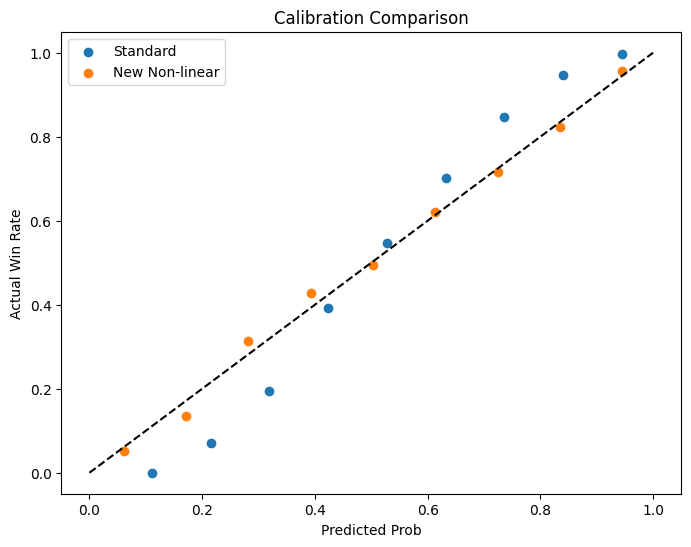

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Load your predictions CSV (with home games)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CBB\Data'
pred_df = pd.read_csv(f'{data_path}\\cbb_predictions_2025.csv')

# Filter to home games
home_df = pred_df[pred_df['venue'] == 'H'].copy()

# Elo diff (positive = home favorite)
home_df['elo_diff'] = home_df['super_elo_team'] - home_df['super_elo_opp']

# Actual home win
home_df['home_win'] = (home_df['team_score'] > home_df['opp_score']).astype(int)

# Add quadratic
home_df['elo_diff_sq'] = home_df['elo_diff'] ** 2

# Fit logistic
X = home_df[['elo_diff', 'elo_diff_sq']]
y = home_df['home_win']
model = LogisticRegression(fit_intercept=True)
model.fit(X, y)

# Params
beta0 = model.intercept_[0]
beta1, beta2 = model.coef_[0]
print(f"Fitted params: beta0={beta0:.4f}, beta1={beta1:.4f}, beta2={beta2:.8f}")

# New probs
home_df['pred_prob_new'] = model.predict_proba(X)[:, 1]
log_loss_new = log_loss(y, home_df['pred_prob_new'])
print(f"New log loss: {log_loss_new:.4f}")

# Standard Elo prob (for comparison, with constant HFA~3.5 equiv points)
scale = 400 / np.log(10)  # ~173.2 for sigmoid equiv
home_df['pred_prob_std'] = 1 / (1 + np.exp(- (home_df['elo_diff'] + 3.5 * (400 / 25)) / scale))  # Adjust constant HFA to Elo scale
log_loss_std = log_loss(y, home_df['pred_prob_std'])
print(f"Standard log loss: {log_loss_std:.4f}")

# Calibration plot for both
def plot_calibration(df, prob_col, label):
    bins = np.linspace(df[prob_col].min(), df[prob_col].max(), 10)
    df['bin'] = pd.cut(df[prob_col], bins=bins)
    bin_stats = df.groupby('bin')[ 'home_win'].mean().reset_index()
    bin_stats['bin_mid'] = bin_stats['bin'].apply(lambda x: x.mid)
    plt.scatter(bin_stats['bin_mid'], bin_stats['home_win'], label=label)

plt.figure(figsize=(8,6))
plot_calibration(home_df, 'pred_prob_std', 'Standard')
plot_calibration(home_df, 'pred_prob_new', 'New Non-linear')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Predicted Prob')
plt.ylabel('Actual Win Rate')
plt.legend()
plt.title('Calibration Comparison')
plt.show()